In [1]:
import os
import sys
import json
import shutil
import numpy as np
import pandas as pd

In [2]:
# Helper function
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_json(src_path):
    with open(src_path, 'r') as json_file:
        data = json.load(json_file)
    return data

def write_json(data,dst_path):
    with open(dst_path, 'w') as outfile:
        json.dump(data, outfile)

https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/

# ResNet152 Retrain Model

In [3]:
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers
from keras.applications.model import ResNet152

C:\Users\TONYLAB\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
columns = ['Biography',
         'Animation',
         'Sci-Fi',
         'Fantasy',
         'Romance',
         'Crime',
         'Mystery',
         'Horror',
         'Thriller',
         'Action',
         'Adventure',
         'Comedy',
         'Drama',
         'Others'] # 14 classes

In [5]:
# read dataframe
train_df = pd.read_csv('./input_df/trainMatrix.csv')
test_df = pd.read_csv('./input_df/testMatrix.csv')
print(train_df.shape)

(3393, 15)


In [6]:
valid_df = train_df.sample(frac = 0.2, random_state = 42)
train_df = train_df.drop(valid_df.index)
print(train_df.shape, valid_df.shape)

(2714, 15) (679, 15)


In [7]:
# 資料路徑
DATASET_PATH  = '../IGimg'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 14

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 32

# Epoch 數
NUM_EPOCHS = 100

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet152-final.h5'

In [8]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(dataframe=train_df,
                                            directory=DATASET_PATH,
                                            x_col="filename",
                                            y_col=columns,
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="other",
                                            target_size=IMAGE_SIZE)

valid_generator=test_datagen.flow_from_dataframe(dataframe=valid_df,
                                                 directory=DATASET_PATH,
                                                 x_col="filename",
                                                 y_col=columns,
                                                 batch_size=BATCH_SIZE,
                                                 seed=42,
                                                 shuffle=True,
                                                 class_mode="other",
                                                 target_size=IMAGE_SIZE)

Found 2714 validated image filenames.
Found 679 validated image filenames.


# Fixed the last Layer from 1000 classes into N classes

In [9]:
# 捨棄 ResNet50 頂層的 fully connected layers
model = ResNet152(include_top=True, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
scale_conv

In [11]:
#只有最後一層需要重新訓練(因為去修改成我們需要一的分類數)
for layer in model.layers:
    layer.trainable = False

In [12]:
#加入最後一層 2D
x = model.get_layer('flatten_1').output
output_layer = Dense(NUM_CLASSES, activation='sigmoid')(x)
retrain_model = Model(inputs=model.input, outputs=output_layer)

In [13]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
retrain_model.compile(optimizer=Adam(lr= 2e-5), #1e-5),
                  loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
retrain_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
scale_conv

# Training Model

In [15]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

In [16]:
# 訓練模型
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss')]

history = retrain_model.fit_generator(generator = train_generator,
                                      steps_per_epoch = STEP_SIZE_TRAIN,
                                      validation_data = valid_generator,
                                      validation_steps = STEP_SIZE_VALID,
                                      epochs = NUM_EPOCHS,
                                      callbacks=callbacks)

Epoch 1/100
84/84 [==============================] - 126s 1s/step - loss: 0.6809 - acc: 0.5960 - val_loss: 0.7180 - val_acc: 0.6033
Epoch 2/100
84/84 [==============================] - 51s 607ms/step - loss: 0.5529 - acc: 0.7451 - val_loss: 0.6979 - val_acc: 0.6091
Epoch 3/100
84/84 [==============================] - 51s 602ms/step - loss: 0.5227 - acc: 0.7753 - val_loss: 0.6863 - val_acc: 0.6102
Epoch 4/100
84/84 [==============================] - 51s 601ms/step - loss: 0.5090 - acc: 0.7848 - val_loss: 0.6830 - val_acc: 0.6138
Epoch 5/100
84/84 [==============================] - 50s 601ms/step - loss: 0.5005 - acc: 0.7916 - val_loss: 0.6817 - val_acc: 0.6149
Epoch 6/100
84/84 [==============================] - 51s 603ms/step - loss: 0.4904 - acc: 0.7943 - val_loss: 0.6728 - val_acc: 0.6182
Epoch 7/100
84/84 [==============================] - 51s 603ms/step - loss: 0.4831 - acc: 0.7988 - val_loss: 0.6747 - val_acc: 0.6179


In [17]:
# 儲存訓練好的模型
retrain_model.save(WEIGHTS_FINAL)

# Plot acc & loss

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])

In [19]:
import matplotlib.pyplot as plt  #匯入 matplotlib.pyplot 模組, 後續程式用 plt 使用

history_dict = history.history
loss_values = history_dict['loss']  #取得每次訓練的 loss 訓練損失分數並存成 loss_values 變數
val_loss_values = history_dict['val_loss']  #取得每次驗證的 val_loss 驗證損失分數並指定給 val_loss_values 變數
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss_values)+ 1)  #len(loss_values) 項目個數為 20,範圍從 1 到 21 (不含 21) 的期間

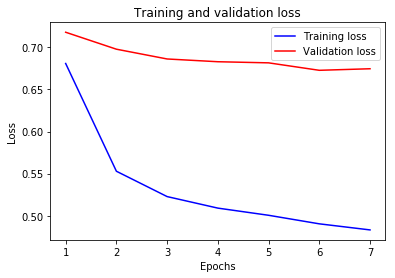

In [20]:
plt.clf()  #清除圖表

plt.plot(epochs, loss_values, 'b', label='Training loss')  #以 'b' 指定用藍色線條畫出 x 軸為訓練週期、y 軸為驗證損失分數的圖表, 標籤設為驗證損失分數
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')  #以 'bo' 指定用藍色點點畫出 x 軸為訓練週期、y 軸為訓練損失分數的圖表, 標籤設為訓練損失分數
plt.title('Training and validation loss')
plt.xlabel('Epochs')  #將此圖表標題的 x 軸設為訓練週期分數
plt.ylabel('Loss')  #將此圖表標題的 y 軸設為損失
plt.legend()  #可以追加每個輸出圖表的圖像名稱

plt.show()  #顯示圖表

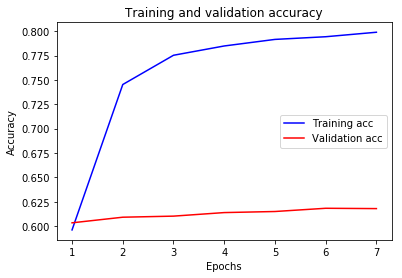

In [21]:
plt.clf()  #清除圖表

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Testing

In [22]:
test_df = pd.read_csv('./input_df/testMatrix.csv')
print(test_df.shape)

(7855, 15)


In [23]:
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=DATASET_PATH,
                                                x_col="filename",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=IMAGE_SIZE)

Found 7855 validated image filenames.


In [24]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [25]:
test_generator.reset()
pred=retrain_model.predict_generator(test_generator,
                                     steps=STEP_SIZE_TEST,
                                     verbose=1)

7855/7855 [==============================] - 360s 46ms/step


# Output

In [26]:
pred.shape

(7855, 14)

In [27]:
predictions = pred

results=pd.DataFrame(predictions, columns=columns)
results["filename"] = test_generator.filenames
ordered_cols = ["filename"] + columns
results = results[ordered_cols] #To get the same column order
results.to_csv("./output/result_ResNet.csv",index=False)

## Label top n dynamic

In [28]:
true_df = test_df

In [29]:
results = pd.read_csv('./output/result_ResNet.csv')
results

,filename,Biography,Animation,Sci-Fi,Fantasy,Romance,Crime,Mystery,Horror,Thriller,Action,Adventure,Comedy,Drama,Others
0,breakthroughmovie_2161.jpg,0.866081,0.321724,0.116832,0.054197,0.253562,0.112494,0.228257,0.668751,0.537384,0.257160,0.469119,0.617221,0.438519,0.143395
1,breakthroughmovie_2165.jpg,0.866047,0.317596,0.114054,0.043013,0.211165,0.104682,0.223614,0.714238,0.532431,0.268396,0.478937,0.625240,0.444124,0.135424
2,breakthroughmovie_2169.jpg,0.866949,0.333130,0.118878,0.048972,0.229909,0.109894,0.225016,0.678420,0.548310,0.261946,0.482614,0.622650,0.446986,0.133867
3,breakthroughmovie_2171.jpg,0.871904,0.361249,0.135810,0.044648,0.186619,0.116498,0.263112,0.748825,0.486824,0.274298,0.552287,0.663689,0.535690,0.168787
4,breakthroughmovie_2173.jpg,0.863187,0.321053,0.111578,0.052592,0.248783,0.111358,0.227200,0.679339,0.537983,0.256142,0.476752,0.623757,0.427084,0.143596
5,breakthroughmovie_2174.jpg,0.814429,0.293392,0.243775,0.063291,0.137873,0.128638,0.286935,0.851437,0.436279,0.334101,0.572059,0.602505,0.529852,0.195329
6,breakthroughmovie_2175.jpg,0.867615,0.321896,0.117638,0.048310,0.230860,0.108115,0.221542,0.687274,0.557932,0.266894,0.489279,0.619173,0.433061,0.134701
7,breakthroughmovie_2179.jpg,0.860282,0.333311,0.135509,0.051644,0.208372,0.110169,0.228630,0.716180,0.523784,0.277003,0.520216,0.636045,0.469124,0.141880
8,breakthroughmovie_2183.jpg,0.866418,0.320399,0.114031,0.049033,0.234627,0.109414,0.223644,0.676688,0.553050,0.255240,0.478046,0.623401,0.425545,0.139479
9,breakthroughmovie_2189.jpg,0.874176,0.307771,0.127328,0.050874,0.217311,0.103860,0.209830,0.698746,0.550950,0.251830,0.484851,0.613224,0.412612,0.136074


In [30]:
labels = read_json('../genresDicOthers.json')

In [31]:
def countAcc(predList, trueList):
    fraction = 0
    denominator = len(trueList)
    for g in predList:
        if g in trueList:
            fraction += 1 
    return fraction / denominator

In [32]:
li = []
for i, row in true_df.iterrows():
    username = row['filename']
    if username == results.loc[i,:]['filename']: # username equals
        print(i, username)
        accname = username.split('_')[0]
        truth = labels[accname]
        numTrue = sum(row[1:])
        print('count:', numTrue)
        
        s = results.loc[i,:][1:]
        top_n = s.sort_values(ascending=False)[:numTrue]
        inList = list(top_n.index)
        
        onehot = []
        for g in columns:
            onehot.append(int(g in inList))
            
        acc = countAcc(inList, truth)
        print(acc, inList, truth)
        
        appList = [username, acc, truth, inList] + onehot
        li.append(appList)
        

0 breakthroughmovie_2161.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Biography', 'Drama']
1 breakthroughmovie_2165.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Biography', 'Drama']
2 breakthroughmovie_2169.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Biography', 'Drama']
3 breakthroughmovie_2171.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Biography', 'Drama']
4 breakthroughmovie_2173.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Biography', 'Drama']
5 breakthroughmovie_2174.jpg
count: 2
0.5 ['Horror', 'Biography'] ['Biography', 'Drama']
6 breakthroughmovie_2175.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Biography', 'Drama']
7 breakthroughmovie_2179.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Biography', 'Drama']
8 breakthroughmovie_2183.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Biography', 'Drama']
9 breakthroughmovie_2189.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Biography', 'Drama']
10 breakthroughmovie_2193.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Biography', 'Drama']
11 breakthroughmovie

187 artofracingmovie_1349.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Drama', 'Romance']
188 fivefeetapartfilm_4225.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Romance']
189 fivefeetapartfilm_4227.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Romance']
190 fivefeetapartfilm_4229.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Romance']
191 fivefeetapartfilm_4230.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Romance']
192 fivefeetapartfilm_4234.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Romance']
193 fivefeetapartfilm_4241.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Romance']
194 fivefeetapartfilm_4244.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Romance']
195 fivefeetapartfilm_4249.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Romance']
196 fivefeetapartfilm_4250.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Romance']
197 fivefeetapartfilm_4251.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama'

0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
327 longshotmovie_6343.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
328 longshotmovie_6349.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
329 longshotmovie_6353.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
330 longshotmovie_6355.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
331 longshotmovie_6358.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
332 longshotmovie_6359.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
333 longshotmovie_6361.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
334 longshotmovie_6362.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
335 longshotmovie_6363.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
336 longshotmovie_6364.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
337 longshotmovie_6365.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Romance']
338 

0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
476 hustlemovie_5370.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
477 hustlemovie_5371.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
478 hustlemovie_5376.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
479 hustlemovie_5377.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
480 hustlemovie_5378.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
481 hustlemovie_5380.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
482 hustlemovie_5384.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
483 hustlemovie_5387.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
484 hustlemovie_5388.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
485 hustlemovie_5393.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
486 hustlemovie_5398.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Crime']
487 hustlemovie_5399.jpg
count: 2
0.0 ['Biography'

0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Thriller']
634 johnwickmovie_5845.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Thriller']
635 johnwickmovie_5847.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Thriller']
636 johnwickmovie_5851.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Thriller']
637 johnwickmovie_5853.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Thriller']
638 johnwickmovie_5857.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Thriller']
639 johnwickmovie_5860.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Thriller']
640 johnwickmovie_5862.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Thriller']
641 johnwickmovie_5863.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Thriller']
642 johnwickmovie_5864.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action

781 thekitchenmovie_9041.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Drama']
782 thekitchenmovie_9042.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Drama']
783 thekitchenmovie_9043.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Drama']
784 thekitchenmovie_9045.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Drama']
785 thekitchenmovie_9047.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Drama']
786 thekitchenmovie_9050.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Drama']
787 thekitchenmovie_9051.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Crime', 'Drama']
788 thekitchenmovie_9052.jpg
count: 3
0.0 ['Horror', 'Biography', 'Comedy'] ['Action', 'Crime', 'Drama']
789 triplefrontier_9934.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Crime']
790 triplefrontier_9935.jpg
count: 3
0.0 ['Biography

0.0 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Fantasy', 'Others']
938 dumbo_3377.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Fantasy', 'Others']
939 dumbo_3379.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Fantasy', 'Others']
940 dumbo_3382.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Fantasy', 'Others']
941 godzillamovie_4448.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Fantasy']
942 godzillamovie_4450.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Fantasy']
943 godzillamovie_4451.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Fantasy']
944 godzillamovie_4457.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Fantasy']
945 godzillamovie_4458.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Fantasy']
946 godzillamovie_4459.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Act

1092 thedeaddontdie_8766.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Fantasy', 'Horror']
1093 thedeaddontdie_8768.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Fantasy', 'Horror']
1094 thedeaddontdie_8769.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Fantasy', 'Horror']
1095 thedeaddontdie_8770.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Fantasy', 'Horror']
1096 thedeaddontdie_8774.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Fantasy', 'Horror']
1097 thedeaddontdie_8775.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Fantasy', 'Horror']
1098 thedeaddontdie_8778.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Fantasy', 'Horror']
1099 thedeaddontdie_8781.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Fantasy', 'Horror']
1100 thedeaddont

0.0 ['Biography'] ['Others']
1253 apollo11movie_1212.jpg
count: 1
0.0 ['Biography'] ['Others']
1254 apollo11movie_1213.jpg
count: 1
0.0 ['Biography'] ['Others']
1255 apollo11movie_1215.jpg
count: 1
0.0 ['Biography'] ['Others']
1256 apollo11movie_1216.jpg
count: 1
0.0 ['Biography'] ['Others']
1257 apollo11movie_1217.jpg
count: 1
0.0 ['Biography'] ['Others']
1258 apollo11movie_1218.jpg
count: 1
0.0 ['Biography'] ['Others']
1259 apollo11movie_1219.jpg
count: 1
0.0 ['Biography'] ['Others']
1260 apollo11movie_1220.jpg
count: 1
0.0 ['Biography'] ['Others']
1261 apollo11movie_1221.jpg
count: 1
0.0 ['Biography'] ['Others']
1262 apollo11movie_1222.jpg
count: 1
0.0 ['Biography'] ['Others']
1263 apollo11movie_1223.jpg
count: 1
0.0 ['Biography'] ['Others']
1264 apollo11movie_1224.jpg
count: 1
0.0 ['Biography'] ['Others']
1265 apollo11movie_1225.jpg
count: 1
0.0 ['Biography'] ['Others']
1266 apollo11movie_1227.jpg
count: 1
0.0 ['Biography'] ['Others']
1267 apollo11movie_1228.jpg
count: 1
0.0 ['Biog

0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1402 hersmellmovie_5000.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1403 hersmellmovie_5001.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1404 hersmellmovie_5002.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1405 hersmellmovie_5003.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1406 hersmellmovie_5004.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1407 hersmellmovie_5005.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1408 hersmellmovie_5007.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1409 hersmellmovie_5008.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1410 hersmellmovie_5009.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1411 hersmellmovie_5010.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1412 hersmellmovie_5011.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1413 hersmellmovi

0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1547 overcomermovie_7121.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Drama', 'Others']
1548 overcomermovie_7122.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Drama', 'Others']
1549 overcomermovie_7123.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Drama', 'Others']
1550 overcomermovie_7124.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Drama', 'Others']
1551 pomsmovie_7215.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Drama', 'Others']
1552 pomsmovie_7216.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Drama', 'Others']
1553 pomsmovie_7218.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Drama', 'Others']
1554 pomsmovie_7219.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Drama', 'Others']
1555 pomsmovie_7220.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Drama', 'Others']
1556 pomsmovie_7222.jpg
coun

count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1696 annabellemovie_819.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1697 annabellemovie_820.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1698 annabellemovie_821.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1699 annabellemovie_823.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1700 annabellemovie_824.jpg
count: 3
0.3333333333333333 ['Biography', 'Comedy', 'Horror'] ['Horror', 'Mystery', 'Thriller']
1701 annabellemovie_825.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1702 annabellemovie_826.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1703 annabellemovie_827.jpg
count: 3

1851 annabellemovie_1055.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1852 annabellemovie_1056.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1853 annabellemovie_1058.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1854 annabellemovie_1059.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1855 annabellemovie_1064.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1856 annabellemovie_1066.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1857 annabellemovie_1067.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']
1858 annabellemovie_1068.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Horror', 'Mystery', 'Thriller']


0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Horror', 'Mystery']
2011 happydeathdaymovie_4751.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Horror', 'Mystery']
2012 happydeathdaymovie_4753.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Horror', 'Mystery']
2013 happydeathdaymovie_4755.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Horror', 'Mystery']
2014 happydeathdaymovie_4757.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Horror', 'Mystery']
2015 happydeathdaymovie_4758.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Horror', 'Mystery']
2016 happydeathdaymovie_4759.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Horror', 'Mystery']
2017 happydeathdaymovie_4762.jpg
count: 3
0.6666666666666666 ['Biography', 'Horror', 'Comedy'] ['Comedy', 'Horror', 'Mystery']
2018 happydeathdaymovie_47

0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2151 midsommarmovie_6631.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2152 midsommarmovie_6632.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2153 midsommarmovie_6633.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2154 midsommarmovie_6634.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2155 midsommarmovie_6635.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2156 midsommarmovie_6636.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2157 midsommarmovie_6637.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2158 petsematarymovie_7126.jpg
count: 3
0.3333333333333333 ['B

0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2296 theintrudermovie_8922.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2297 theintrudermovie_8923.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2298 theintrudermovie_8926.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2299 theintrudermovie_8928.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2300 theintrudermovie_8929.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2301 theintrudermovie_8930.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2302 theintrudermovie_8931.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Horror', 'Mystery']
2303 theintrudermovie_8932.jpg
count: 3
0.333333

0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Drama', 'Horror']
2451 47metersdown_21.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Drama', 'Horror']
2452 47metersdown_22.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Drama', 'Horror']
2453 47metersdown_23.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Drama', 'Horror']
2454 47metersdown_24.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Drama', 'Horror']
2455 47metersdown_25.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Drama', 'Horror']
2456 47metersdown_27.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Drama', 'Horror']
2457 47metersdown_28.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Drama', 'Horror']
2458 47metersdown_29.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror

0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Horror']
2612 escaperoom_3396.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Horror']
2613 escaperoom_3397.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Horror']
2614 escaperoom_3398.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Horror']
2615 escaperoom_3399.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Horror']
2616 escaperoom_3400.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Horror']
2617 escaperoom_3401.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Horror']
2618 escaperoom_3403.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Horror']
2619 escaperoom_3404.jpg
count: 3
0.3333333333333333 ['Biography',

count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2761 theprodigymovie_9407.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2762 theprodigymovie_9408.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2763 theprodigymovie_9409.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2764 theprodigymovie_9411.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2765 theprodigymovie_9412.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2766 theprodigymovie_9413.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2767 theprodigymovie_9414.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2768 theprodigymovie_9415.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2769 theprodigymovie_9416.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2770 theprodigymovie_9417.jpg
count: 2
0.5 ['Biography', 'Horror'] ['Horror', 'Thriller']
2771 theprodigymovie_9418.jpg
count: 2
0

2925 angrybirdsmovie_750.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
2926 angrybirdsmovie_751.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
2927 angrybirdsmovie_753.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
2928 angrybirdsmovie_754.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
2929 angrybirdsmovie_755.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
2930 angrybirdsmovie_756.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
2931 angrybirdsmovie_758.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
2932 angrybirdsmovie_759.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure',

3060 httydragon_5237.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3061 httydragon_5240.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3062 httydragon_5241.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3063 httydragon_5242.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3064 httydragon_5243.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3065 httydragon_5245.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3066 httydragon_5246.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3067 httydragon_5248.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3068 httydragon_5249.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3069 httydragon_525

0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3204 missinglinkfilm_6733.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3205 missinglinkfilm_6734.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3206 missinglinkfilm_6735.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3207 missinglinkfilm_6736.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3208 missinglinkfilm_6737.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3209 missinglinkfilm_6738.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3210 missinglinkfilm_6739.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3211 mi

0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3362 secretlifeofpets_7589.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3363 secretlifeofpets_7591.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3364 secretlifeofpets_7592.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3365 secretlifeofpets_7595.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3366 secretlifeofpets_7596.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3367 secretlifeofpets_7598.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3368 secretlifeofpets_7600.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']


3508 secretlifeofpets_7787.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3509 secretlifeofpets_7788.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3510 secretlifeofpets_7790.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3511 secretlifeofpets_7792.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3512 secretlifeofpets_7793.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3513 secretlifeofpets_7794.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3514 secretlifeofpets_7795.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3515 secretlifeofpets_7796.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy

3662 thelegomovie_9189.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3663 thelegomovie_9190.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3664 thelegomovie_9192.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3665 thelegomovie_9196.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3666 thelegomovie_9197.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3667 thelegomovie_9198.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3668 thelegomovie_9199.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3669 thelegomovie_9201.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3670 thelegomovie_9202.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Animation']
3

0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3826 toystory_9925.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3827 toystory_9926.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3828 toystory_9927.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3829 toystory_9928.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3830 toystory_9929.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3831 toystory_9930.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3832 uglydolls_9984.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3833 uglydolls_9985.jpg
count: 3
0.3333333333333333 ['B

3974 wonderparkmovie_10456.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3975 wonderparkmovie_10458.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3976 wonderparkmovie_10459.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3977 wonderparkmovie_10463.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3978 wonderparkmovie_10465.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3979 wonderparkmovie_10466.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3980 wonderparkmovie_10467.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
3981 wonderparkmovie_10468.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy

0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4140 angelhasfallen_604.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4141 angelhasfallen_605.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4142 angelhasfallen_606.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4143 angelhasfallen_607.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4144 angelhasfallen_608.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4145 angelhasfallen_609.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4146 angelhasfallen_610.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4147 angelhasfallen_611.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4148 angelhasfallen_612.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4149 angelhasfallen_613.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Thriller']
4150 angelhasfallen_614.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Ac

0.0 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Sci-Fi', 'Thriller']
4285 glassmovie_4315.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Sci-Fi', 'Thriller']
4286 glassmovie_4316.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Sci-Fi', 'Thriller']
4287 glassmovie_4317.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Sci-Fi', 'Thriller']
4288 glassmovie_4318.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Sci-Fi', 'Thriller']
4289 glassmovie_4319.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Sci-Fi', 'Thriller']
4290 glassmovie_4320.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Sci-Fi', 'Thriller']
4291 glassmovie_4321.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Sci-Fi', 'Thriller']
4292 glassmovie_4322.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Sci-Fi', 'Thriller']
4293 glassmovie_4324.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Drama', 'Sci-Fi', 'Thril

0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4432 alitamovie_310.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4433 alitamovie_311.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4434 alitamovie_313.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4435 alitamovie_314.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4436 alitamovie_315.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4437 alitamovie_316.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4438 alitamovie_317.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4439 alitamovie_318.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4440 alitamovie_319.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adven

0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4570 avengers_1352.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4571 avengers_1354.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4572 avengers_1355.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4573 avengers_1356.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4574 avengers_1357.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4575 avengers_1358.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4576 avengers_1359.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4577 avengers_1361.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4578 avengers_1363.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'S

count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4721 avengers_1570.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4722 avengers_1571.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4723 avengers_1573.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4724 avengers_1574.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4725 avengers_1575.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4726 avengers_1576.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4727 avengers_1578.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4728 avengers_1579.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4729 avengers_1580.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adven

count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4865 captainmarvelofficial_2493.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4866 captainmarvelofficial_2496.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4867 captainmarvelofficial_2499.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4868 captainmarvelofficial_2500.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4869 captainmarvelofficial_2502.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4870 captainmarvelofficial_2503.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4871 captainmarvelofficial_2504.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
4872 captainmarvelofficial_2506.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adven

0.0 ['Biography'] ['Sci-Fi']
5021 clarathefilm_2854.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5022 clarathefilm_2856.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5023 clarathefilm_2858.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5024 clarathefilm_2859.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5025 clarathefilm_2860.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5026 clarathefilm_2862.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5027 clarathefilm_2864.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5028 clarathefilm_2865.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5029 clarathefilm_2866.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5030 clarathefilm_2868.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5031 clarathefilm_2869.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5032 clarathefilm_2870.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5033 clarathefilm_2871.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5034 clarathefilm_2872.jpg
count: 1
0.0 ['Biography'] ['Sci-Fi']
5035 clarathefilm_2873.jpg
count: 1
0.0 ['Biography'] ['Sci-F

0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5161 spidermanmovie_8255.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5162 spidermanmovie_8256.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5163 spidermanmovie_8258.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5164 spidermanmovie_8259.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5165 spidermanmovie_8261.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5166 spidermanmovie_8262.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5167 spidermanmovie_8263.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5168 spidermanmovie_8264.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5169 spidermanmovie_8265.jpg
count: 3
0.0 ['Biog

5308 spidermanmovie_8447.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5309 spidermanmovie_8448.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5310 spidermanmovie_8449.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5311 spidermanmovie_8451.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5312 spidermanmovie_8452.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5313 spidermanmovie_8453.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5314 spidermanmovie_8457.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5315 spidermanmovie_8458.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5316 spidermanmovie_8459.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5317 spide

0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5464 xmenmovies_10649.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5465 xmenmovies_10650.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5466 xmenmovies_10652.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5467 xmenmovies_10653.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5468 xmenmovies_10654.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5469 xmenmovies_10657.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5470 xmenmovies_10658.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5471 xmenmovies_10659.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5472 xmenmovies_10660.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy']

5616 xmenmovies_10849.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5617 xmenmovies_10850.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5618 xmenmovies_10853.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5619 xmenmovies_10854.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5620 xmenmovies_10855.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5621 xmenmovies_10856.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5622 xmenmovies_10857.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5623 xmenmovies_10858.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5624 xmenmovies_10859.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5625 xmenmovies_10860.jpg
count: 3
0.

0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5779 xmenmovies_11049.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5780 xmenmovies_11051.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5781 xmenmovies_11052.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5782 xmenmovies_11053.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5783 xmenmovies_11054.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5784 xmenmovies_11055.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5785 xmenmovies_11056.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5786 xmenmovies_11057.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Sci-Fi']
5787 xmenmovies_11058.jpg
count: 3
0.0 ['Biography', 'Horror', 'Comedy']

0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Comedy', 'Drama']
5937 adogsjourneymovie_113.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Comedy', 'Drama']
5938 adogsjourneymovie_114.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Comedy', 'Drama']
5939 adogsjourneymovie_115.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Comedy', 'Drama']
5940 adogsjourneymovie_116.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Comedy', 'Drama']
5941 adogsjourneymovie_117.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Comedy', 'Drama']
5942 adogsjourneymovie_118.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Comedy', 'Drama']
5943 adogsjourneymovie_119.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Adventure', 'Comedy', 'Drama']
5944 adogsjourneymovie_120.jpg
c

0.0 ['Biography', 'Horror'] ['Adventure', 'Drama']
6088 arcticmovie_1279.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Adventure', 'Drama']
6089 arcticmovie_1280.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Adventure', 'Drama']
6090 arcticmovie_1281.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Adventure', 'Drama']
6091 arcticmovie_1282.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Adventure', 'Drama']
6092 brittanyrunsmov_2439.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Comedy', 'Drama']
6093 brittanyrunsmov_2440.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6094 brittanyrunsmov_2441.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6095 brittanyrunsmov_2442.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6096 brittanyrunsmov_2443.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6097 brittanyrunsmov_2444.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6098 brittanyrunsmov_2445.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Dram

6249 latenightmovie_6051.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6250 latenightmovie_6052.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6251 latenightmovie_6053.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6252 latenightmovie_6054.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6253 latenightmovie_6055.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6254 latenightmovie_6056.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Comedy', 'Drama']
6255 latenightmovie_6057.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6256 latenightmovie_6058.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6257 latenightmovie_6059.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6258 latenightmovie_6060.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6259 latenightmovie_6061.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6260 latenightmovie_6062.jpg
count: 2
0.0 ['Biography'

0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6386 thefarewell_8874.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6387 thefarewell_8875.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6388 thefarewell_8876.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6389 themustangfilm_9299.jpg
count: 1
0.0 ['Biography'] ['Drama']
6390 themustangfilm_9300.jpg
count: 1
0.0 ['Biography'] ['Drama']
6391 themustangfilm_9301.jpg
count: 1
0.0 ['Biography'] ['Drama']
6392 themustangfilm_9302.jpg
count: 1
0.0 ['Biography'] ['Drama']
6393 themustangfilm_9303.jpg
count: 1
0.0 ['Biography'] ['Drama']
6394 themustangfilm_9304.jpg
count: 1
0.0 ['Biography'] ['Drama']
6395 themustangfilm_9305.jpg
count: 1
0.0 ['Biography'] ['Drama']
6396 themustangfilm_9306.jpg
count: 1
0.0 ['Biography'] ['Drama']
6397 themustangfilm_9307.jpg
count: 1
0.0 ['Biography'] ['Drama']
6398 themustangfilm_9308.jpg
count: 1
0.0 ['Biography'] ['Drama']
6399 themustangfilm_9309.jpg
count: 1
0.0 [

count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6545 theupsidefilm_9644.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6546 theupsidefilm_9645.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6547 theupsidefilm_9646.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6548 theupsidefilm_9647.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6549 theupsidefilm_9648.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6550 theupsidefilm_9649.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6551 theupsidefilm_9650.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6552 theupsidefilm_9651.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6553 theupsidefilm_9652.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6554 theupsidefilm_9653.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6555 theupsidefilm_9654.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Comedy', 'Drama']
6556 the

0.0 ['Biography'] ['Comedy']
6691 beachbummovie_1824.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6692 beachbummovie_1825.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6693 beachbummovie_1826.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6694 beachbummovie_1827.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6695 beachbummovie_1828.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6696 beachbummovie_1829.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6697 beachbummovie_1830.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6698 beachbummovie_1831.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6699 beachbummovie_1832.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6700 beachbummovie_1833.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6701 beachbummovie_1834.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6702 beachbummovie_1835.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6703 beachbummovie_1836.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6704 beachbummovie_1837.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6705 beachbummovie_1838.jpg
count: 1
0.0 ['Biog

0.0 ['Biography'] ['Comedy']
6836 booksmart_2127.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6837 booksmart_2128.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6838 booksmart_2129.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6839 booksmart_2130.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6840 booksmart_2131.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6841 booksmart_2132.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6842 booksmart_2133.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6843 booksmart_2134.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6844 booksmart_2135.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6845 booksmart_2136.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6846 booksmart_2137.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6847 booksmart_2138.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6848 booksmart_2139.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6849 booksmart_2140.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6850 booksmart_2141.jpg
count: 1
0.0 ['Biography'] ['Comedy']
6851 booksmart_2142.jpg
count: 1
0.0 ['Bi

count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
6994 detectivepikachumovie_3110.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
6995 detectivepikachumovie_3111.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
6996 detectivepikachumovie_3112.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
6997 detectivepikachumovie_3113.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
6998 detectivepikachumovie_3114.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
6999 detectivepikachumovie_3115.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7000 detectivepikachumovie_3116.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Ad

0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7140 meninblack_6539.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7141 meninblack_6540.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7142 meninblack_6541.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7143 meninblack_6542.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7144 meninblack_6543.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7145 meninblack_6544.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7146 meninblack_6545.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7147 meninblack_6546.jpg
count: 3
0.3333333333333333 ['Biography',

7280 shazammovie_8124.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7281 shazammovie_8125.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7282 shazammovie_8126.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7283 shazammovie_8127.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7284 shazammovie_8128.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7285 shazammovie_8129.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7286 shazammovie_8130.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7287 shazammovie_8131.jpg
count: 3
0.3333333333333333 ['Biography', 'Horror', 'Comedy'] ['Action', 'Adventure', 'Comedy']
7288 shazammovie_8132.jp

0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7426 fastandfuriousmovie_3682.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7427 fastandfuriousmovie_3683.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7428 fastandfuriousmovie_3684.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7429 fastandfuriousmovie_3685.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7430 fastandfuriousmovie_3686.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Action', 'Adventure']
7431 fastandfuriousmovie_3687.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7432 fastandfuriousmovie_3688.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7433 fastandfuriousmovie_3689.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7434 fastandfuriousmovie_3690.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Action', 'Adventure']
7435 fastandfuriousmovie_3691.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure'

count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7580 fastandfuriousmovie_3836.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Action', 'Adventure']
7581 fastandfuriousmovie_3837.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Action', 'Adventure']
7582 fastandfuriousmovie_3838.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7583 fastandfuriousmovie_3839.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7584 fastandfuriousmovie_3840.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7585 fastandfuriousmovie_3841.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7586 fastandfuriousmovie_3842.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7587 fastandfuriousmovie_3843.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7588 fastandfuriousmovie_3844.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7589 fastandfuriousmovie_3845.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'A

0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7725 fastandfuriousmovie_3981.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7726 fastandfuriousmovie_3982.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Action', 'Adventure']
7727 fastandfuriousmovie_3983.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Action', 'Adventure']
7728 fastandfuriousmovie_3984.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7729 fastandfuriousmovie_3985.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7730 fastandfuriousmovie_3986.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7731 fastandfuriousmovie_3987.jpg
count: 2
0.0 ['Horror', 'Biography'] ['Action', 'Adventure']
7732 fastandfuriousmovie_3988.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7733 fastandfuriousmovie_3989.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure']
7734 fastandfuriousmovie_3990.jpg
count: 2
0.0 ['Biography', 'Horror'] ['Action', 'Adventure'

In [33]:
acc_df = pd.DataFrame(li, columns = ['username', 'acc', 'truth', 'top_n'] + columns)
acc_df

,username,acc,truth,top_n,Biography,Animation,Sci-Fi,Fantasy,Romance,Crime,Mystery,Horror,Thriller,Action,Adventure,Comedy,Drama,Others
0,breakthroughmovie_2161.jpg,0.5,"[Biography, Drama]","[Biography, Horror]",1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,breakthroughmovie_2165.jpg,0.5,"[Biography, Drama]","[Biography, Horror]",1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,breakthroughmovie_2169.jpg,0.5,"[Biography, Drama]","[Biography, Horror]",1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,breakthroughmovie_2171.jpg,0.5,"[Biography, Drama]","[Biography, Horror]",1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,breakthroughmovie_2173.jpg,0.5,"[Biography, Drama]","[Biography, Horror]",1,0,0,0,0,0,0,1,0,0,0,0,0,0
5,breakthroughmovie_2174.jpg,0.5,"[Biography, Drama]","[Horror, Biography]",1,0,0,0,0,0,0,1,0,0,0,0,0,0
6,breakthroughmovie_2175.jpg,0.5,"[Biography, Drama]","[Biography, Horror]",1,0,0,0,0,0,0,1,0,0,0,0,0,0
7,breakthroughmovie_2179.jpg,0.5,"[Biography, Drama]","[Biography, Horror]",1,0,0,0,0,0,0,1,0,0,0,0,0,0
8,breakthroughmovie_2183.jpg,0.5,"[Biography, Drama]","[Biography, Horror]",1,0,0,0,0,0,0,1,0,0,0,0,0,0
9,breakthroughmovie_2189.jpg,0.5,"[Biography, Drama]","[Biography, Horror]",1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [34]:
acc_df.to_csv('./output/result_ResNet_bi.csv', index = 0)

In [35]:
acc_df['acc'].mean()

0.13863781031190658

# Heatmap

In [36]:
savePath = './Heatmap/'
newPath(savePath)

In [37]:
#預先處理輸入影像
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

filename = 'longshotmovie_10022.jpg'
img_path = '../IGimg/' + filename

img = image.load_img(img_path, target_size=IMAGE_SIZE)
print(type(img))  # 目前圖片為 <class 'PIL.Image.Image'> 物件
print(img.size)  # 可以用 size 屬性查看尺寸 -> (224, 224)

x = image.img_to_array(img) 	# 將 PIL 物件轉為 float32 的 Numpy 陣列
print(x.shape) 				# shape=(224, 224, 3)


# 將 x 陣列 (可視為張量) 增加一個批次軸, shape=(1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
print(x.shape)

x = preprocess_input(x) # 預處理批次量 (這會對每一 channel 做顏色值正規化)


FileNotFoundError: [Errno 2] No such file or directory: '../IGimg/longshotmovie_10022.jpg'

In [ ]:
# 預測圖片類別
preds = retrain_model.predict(x)
print(preds.shape)
print(preds)
# print('預測結果:', decode_predictions(preds, top=3)[0])

g = np.argmax(preds[0])
print('belong to:', g)

In [ ]:
# 設定 Gard-CAM 演算法
from keras import backend as K

g_output = model.output[:, g] # ← 預測向量中的 "非洲象" 項目

last_conv_layer = model.get_layer('res5c_branch2c') # block5_conv3 層的輸出特徵圖, 其為 VGG16 中的最後一個卷積層

grads = K.gradients(g_output, last_conv_layer.output)[0] #  block5_conv3 的輸出特徵圖中關於 "非洲象" 類別的梯度

pooled_grads = K.mean(grads, axis=(0, 1, 2)) #  轉換成向量 shape = (512, ), 其中每個項目是特定特徵圖 channel 的梯度平均強度(值)

#  給定輸入影像的條件下, 讓我們可以存取剛剛定義的數值：pooled_grads 和 block5_conv3 的輸出特徵圖
iterate = K.function([retrain_model.input], 
    [pooled_grads, last_conv_layer.output[0]])

#  對於給定的兩隻大象樣本影像, 產生這兩個量值, 以 Numpy 陣列呈現
pooled_grads_value, conv_layer_output_value = iterate([x])

# 將特徵圖陣列中的每個 channel 與 "大象" 類別相關的 "此 channel 的重要程度" 相乘
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 特徵圖的跨 channel 平均值是類別激活函數輸出的熱圖
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [ ]:
# heatmap 後期處理
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [ ]:
# 將熱圖與原始影像疊加在一起
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img # 這裡 0.4 是熱圖強度因子

dst = savePath + filename
print('Save successfully:', cv2.imwrite(dst, superimposed_img))